# Fase 4.3

In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from collections import defaultdict

from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm


def report(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")

In [2]:
class_name = 'TRACK_genre_top_num'
df = pd.read_csv('flat_df_no_nulli_no_out.csv', skipinitialspace=True, na_values='?', keep_default_na=True)
df = df[df.TRACK_genre_top.isna() == False]
df['TRACK_genre_top_num'] = [1 if genre == "Rock" else 0 for genre in df["TRACK_genre_top"]]

df

,track_id,ALBUM_date_released_year,ALBUM_favorites,ALBUM_type,ALBUM_tags,ALBUM_tracks,ALBUM_listens,ALBUM_title,SET_subset,ARTIST_favorites,...,spectral_contraststd,tonnetzkurtosis,tonnetzmax,tonnetzmean,tonnetzmedian,tonnetzmin,tonnetzskew,tonnetzstd,ARTIST_location_,TRACK_genre_top_num
0,2,2009.0,4.0,Album,[],7.0,6073.0,AWOL - A Way Of Life,small,2.302585,...,0.746760,1.335255,-0.069000,0.063224,-0.055764,0.206749,-0.152102,-0.075675,North America,0
1,3,2009.0,4.0,Album,[],7.0,6073.0,AWOL - A Way Of Life,medium,2.302585,...,1.221668,0.087193,-0.092808,-0.029543,0.014404,0.106603,-0.251621,-0.060280,North America,0
2,5,2009.0,4.0,Album,[],7.0,6073.0,AWOL - A Way Of Life,small,2.302585,...,1.546327,3.707580,-0.159586,0.005594,-0.004815,0.052547,-0.209312,-0.052692,North America,0
3,10,2008.0,4.0,Album,[],2.0,47632.0,Constant Hitmaker,small,4.317488,...,1.987875,1.841458,-0.089548,-0.084626,0.077173,-0.015011,-0.360596,-0.026267,NaN,0
9,134,2009.0,4.0,Album,[],7.0,6073.0,AWOL - A Way Of Life,medium,2.302585,...,2.088149,6.580380,-0.146649,-0.041780,0.039949,0.023004,-1.213183,-0.056095,North America,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
104466,155315,2017.0,0.0,Live Performance,[],6.0,1506.0,"Live at Monty Hall, 2/17/2017",large,0.000000,...,0.896165,-1.260438,-0.059327,0.022795,-0.011546,0.097424,0.618452,0.003335,North America,1
104467,155316,2017.0,0.0,Live Performance,[],6.0,1506.0,"Live at Monty Hall, 2/17/2017",large,0.000000,...,-1.297131,-0.902569,-0.010471,0.090281,-0.104228,-0.123058,0.233260,0.021846,North America,1
104468,155317,2017.0,0.0,Live Performance,[],6.0,1506.0,"Live at Monty Hall, 2/17/2017",large,0.000000,...,0.528187,-1.008135,0.155377,-0.135316,0.154183,-0.131252,-0.439485,0.051446,North America,1
104469,155318,2017.0,0.0,Live Performance,[],6.0,1506.0,"Live at Monty Hall, 2/17/2017",large,0.000000,...,-0.882132,-0.492957,0.030095,0.042125,-0.049494,-0.081322,-0.305773,-0.001345,North America,1


In [3]:
features = [
 'chroma_censkurtosis',
 'chroma_censmax',
 'chroma_censmean',
 'chroma_censmedian',
 'chroma_censmin',
 'chroma_censskew',
 'chroma_censstd',
 'chroma_censcqtkurtosis',
 'chroma_cqtmax',
 'chroma_cqtmean',
 'chroma_cqtmedian',
 'chroma_cqtmin',
 'chroma_cqtskew',
 'chroma_cqtstd',
 'chroma_stftkurtosis',
 'chroma_stftmax',
 'chroma_stftmean',
 'chroma_stftmedian',
 'chroma_stftmin',
 'chroma_stftskew',
 'chroma_stftstd',
 'mfcckurtosis',
 'mfccmax',
 'mfccmean',
 'mfccmedian',
 'mfccmin',
 'mfccskew',
 'mfccstd',
 'spectral_contrastkurtosis',
 'spectral_contrastmax',
 'spectral_contrastmean',
 'spectral_contrastmedian',
 'spectral_contrastmin',
 'spectral_contrastskew',
 'spectral_contraststd',
 'tonnetzkurtosis',
 'tonnetzmax',
 'tonnetzmean',
 'tonnetzmedian',
 'tonnetzmin',
 'tonnetzskew',
 'tonnetzstd',
 'rmsekurtosis01',
 'rmsemax01',
 'rmsemean01',
 'rmsemedian01',
 'rmsemin01',
 'rmseskew01',
 'rmsestd01',
 'spectral_bandwidthkurtosis01',
 'spectral_bandwidthmax01',
 'spectral_bandwidthmean01',
 'spectral_bandwidthmedian01',
 'spectral_bandwidthmin01',
 'spectral_bandwidthskew01',
 'spectral_bandwidthstd01',
 'spectral_centroidkurtosis01',
 'spectral_centroidmax01',
 'spectral_centroidmean01',
 'spectral_centroidmedian01',
 'spectral_centroidmin01',
 'spectral_centroidskew01',
 'spectral_centroidstd01',
 'spectral_rolloffkurtosis01',
 'spectral_rolloffmax01',
 'spectral_rolloffmean01',
 'spectral_rolloffmedian01',
 'spectral_rolloffmin01',
 'spectral_rolloffskew01',
 'spectral_rolloffstd01',
 'zcrkurtosis01',
 'zcrmax01',
 'zcrmean01',
 'zcrmedian01',
 'zcrmin01',
 'zcrskew01',
 'zcrstd01',
]


bitmap = [
    'Blues',
 'Classical',
 'Country',
 'Easy Listening',
 'Electronic',
 'Experimental',
 'Folk',
 'Hip-Hop',
 'Instrumental',
 'International',
 'Jazz',
 'Old-Time / Historic',
 'Pop',
 'Rock',
 'Soul-RnB',
 'Spoken',
]

nulli = [
     'ALBUM_date_released_year',
    'ALBUM_favorites',
     'ALBUM_listens',
 'ALBUM_tracks',
 'ALBUM_type',
 'ARTIST_favorites',
 'ARTIST_location',
 'TRACK_favorites',
  'ARTIST_location_',
    'TRACK_genres_soloTop'
]

nonNumerici = [
    'ALBUM_tags',
    'ALBUM_title',
    'ARTIST_location_',
    'ARTIST_name',
    'ARTIST_tags',
    'SET_subset',
    'TRACK_genre_top',
    'TRACK_genres',
    'TRACK_genres_all',
    'TRACK_genres_soloTop',
    'TRACK_tags',
    'TRACK_title',
    'TRACK_genres_soloTop',
    'ALBUM_type_',
    'track_id'
]

attributi = [
    "mfccskew",
    "mfccmedian",
    "spectral_bandwidthmean01",
    "chroma_stftmedian",
    "mfccmax",
    "zcrstd01",
    "rmsekurtosis01",
    "ARTIST_favorites_",
    "spectral_centroidstd01",
    #"ALBUM_date_released_year_",
    "zcrmedian01",
    "spectral_contrastmin",
    "chroma_cqtstd",
    #"ALBUM_type_"
]

def Diff(li1, li2):
    return list(set(li1)-set(li2))

tutti = list(df.columns)

compl = Diff(tutti, features + bitmap + nonNumerici + nulli+ ['target'])

compl.sort()

compl

['ALBUM_date_released_year_',
 'ALBUM_favorites_',
 'ALBUM_listens_',
 'ALBUM_tracks_',
 'ARTIST_favorites_',
 'TRACK_bitrate',
 'TRACK_duration',
 'TRACK_genre_top_num',
 'TRACK_interest',
 'TRACK_listens',
 'TRACK_number']

In [4]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, LabelEncoder

label_encoders = dict()
column2encode = ['ALBUM_type_']

for col in column2encode:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le

X = df[attributi].values

scaler = StandardScaler()
#scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)


In [5]:
types = df['ALBUM_type_']
types.values

array([0, 0, 0, ..., 1, 1, 1])

In [6]:
from sklearn.preprocessing import KBinsDiscretizer

In [7]:
n_bins=5
est = KBinsDiscretizer(n_bins=n_bins, encode='ordinal', strategy='quantile')
Xt = est.fit_transform(X_scaled)

In [8]:
X = pd.DataFrame(Xt, columns=attributi)
X['ALBUM_type_'] = types.values
X

,mfccskew,mfccmedian,spectral_bandwidthmean01,chroma_stftmedian,mfccmax,zcrstd01,rmsekurtosis01,ARTIST_favorites_,spectral_centroidstd01,zcrmedian01,spectral_contrastmin,chroma_cqtstd,ALBUM_type_
0,3.0,1.0,3.0,1.0,1.0,4.0,3.0,3.0,3.0,4.0,1.0,3.0,0
1,3.0,1.0,3.0,3.0,0.0,4.0,0.0,3.0,4.0,4.0,0.0,3.0,0
2,2.0,2.0,2.0,1.0,3.0,3.0,1.0,3.0,3.0,2.0,1.0,2.0,0
3,3.0,1.0,2.0,2.0,1.0,3.0,3.0,4.0,3.0,4.0,2.0,4.0,0
4,2.0,2.0,2.0,2.0,2.0,3.0,3.0,3.0,3.0,3.0,1.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
48917,2.0,2.0,1.0,3.0,3.0,0.0,1.0,0.0,1.0,2.0,4.0,1.0,1
48918,4.0,2.0,1.0,3.0,3.0,0.0,3.0,0.0,0.0,1.0,3.0,4.0,1
48919,2.0,2.0,1.0,4.0,2.0,0.0,4.0,0.0,1.0,1.0,2.0,2.0,1
48920,2.0,2.0,2.0,4.0,2.0,0.0,4.0,0.0,1.0,2.0,3.0,3.0,1


In [9]:
est.bin_edges_

array([array([-6.60157999, -0.75505851, -0.34840268,  0.08031716,  0.70504038,
       25.78207653]),
       array([-3.08171308, -0.85123871, -0.36340198,  0.13732284,  0.82721131,
        7.53109369]),
       array([-2.82049265, -0.81041402, -0.27094568,  0.1893071 ,  0.77370362,
        5.85327925]),
       array([-3.36707276, -0.83605547, -0.23256212,  0.25582105,  0.82063043,
        3.8265123 ]),
       array([-2.50369798, -0.78354836, -0.39981499,  0.02964627,  0.66854386,
       10.89648468]),
       array([-1.43088865, -0.74181449, -0.4353779 , -0.05091084,  0.59604917,
       14.13335572]),
       array([-9.47978529e-02, -6.11407442e-02, -4.70119471e-02, -2.98583395e-02,
        2.39345942e-03,  1.80792735e+02]),
       array([-0.28034841, -0.26305614, -0.24576388, -0.19388708, -0.03825669,
       16.37210328]),
       array([-1.87076244, -0.82700879, -0.40243665,  0.07342454,  0.72795666,
       12.12147759]),
       array([-1.42387030e+00, -6.71060495e-01, -3.39824181e-01,  2

## K-modes

In [10]:
from kmodes.kmodes import KModes

n_cluster=8
km = KModes(n_clusters=n_cluster, init='Huang', n_init=5, verbose=1, n_jobs=-1)

clusters = km.fit_predict(X)

Best run was number 5


In [11]:
clusters

array([4, 5, 7, ..., 7, 7, 7], dtype=uint16)

In [12]:
km.cost_

339560.0

In [13]:
centroids = km.cluster_centroids_

In [14]:
clusters_df = pd.DataFrame({'mfccskew': centroids[:, 0], 'mfccmedian': centroids[:, 1], 
                            'spectral_bandwidthmean01': centroids[:, 2],
                            'chroma_stftmedian': centroids[:, 3], 'mfccmax': centroids[:, 4],
                            'zcrstd01': centroids[:, 5], 'rmsekurtosis01': centroids[:, 6],
                            'ARTIST_favorites_': centroids[:, 7], 'spectral_centroidstd01': centroids[:,8],
                            'zcrmedian01': centroids[:, 9],'spectral_contrastmin': centroids[:, 10],
                            'chroma_cqtstd': centroids[:, 11], 'ALBUM_type_': centroids[:, 12],
                            'cluster': range(0,n_cluster)})
clusters_df

,mfccskew,mfccmedian,spectral_bandwidthmean01,chroma_stftmedian,mfccmax,zcrstd01,rmsekurtosis01,ARTIST_favorites_,spectral_centroidstd01,zcrmedian01,spectral_contrastmin,chroma_cqtstd,ALBUM_type_,cluster
0,0.0,4.0,4.0,2.0,4.0,3.0,4.0,2.0,2.0,4.0,4.0,4.0,0.0,0
1,0.0,3.0,3.0,2.0,2.0,3.0,2.0,1.0,3.0,3.0,2.0,0.0,0.0,1
2,3.0,3.0,0.0,0.0,4.0,0.0,2.0,0.0,0.0,0.0,4.0,4.0,0.0,2
3,4.0,0.0,1.0,3.0,3.0,0.0,3.0,3.0,0.0,2.0,4.0,4.0,0.0,3
4,4.0,0.0,4.0,4.0,0.0,4.0,2.0,0.0,2.0,4.0,1.0,3.0,0.0,4
5,2.0,1.0,4.0,3.0,0.0,4.0,0.0,4.0,4.0,3.0,0.0,0.0,0.0,5
6,1.0,4.0,0.0,0.0,4.0,0.0,4.0,4.0,1.0,0.0,0.0,0.0,0.0,6
7,3.0,2.0,2.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,2.0,2.0,0.0,7


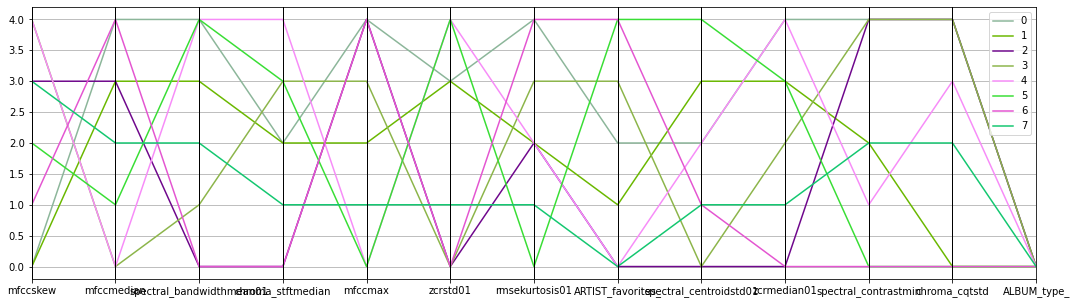

In [15]:
plt.figure(figsize=(18,5))
pd.plotting.parallel_coordinates(clusters_df, "cluster");

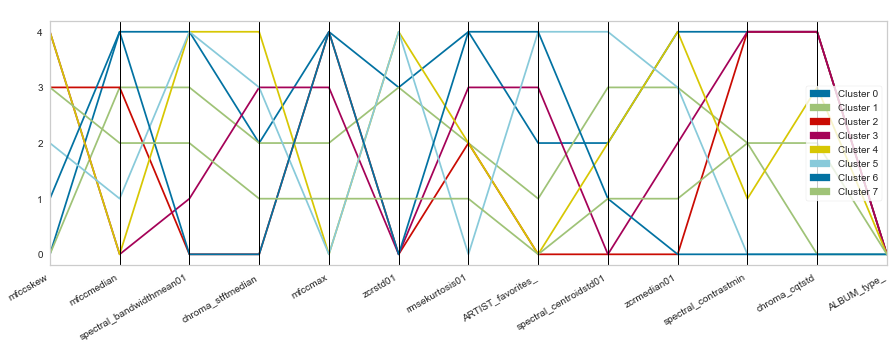

In [16]:
from yellowbrick.features.pcoords import parallel_coordinates
from yellowbrick.features import ParallelCoordinates

# Specify the features of interest and the classes of the target
features = [
    "mfccskew",
    "mfccmedian",
    "spectral_bandwidthmean01",
    "chroma_stftmedian",
    "mfccmax",
    "zcrstd01",
    "rmsekurtosis01",
    "ARTIST_favorites_",
    "spectral_centroidstd01",
    #"released_year_",
    "zcrmedian01",
    "spectral_contrastmin",
    "chroma_cqtstd",
    "ALBUM_type_"
]

classes = []

for i in range(n_cluster):
    classes.append("Cluster "+str(i))

# Instantiate the visualizer
visualizer = ParallelCoordinates(
    classes=classes, features=features,
    size=(1080, 360), alpha=1,
    title=" "
)

# Fit and transform the data to the visualizer
visualizer.fit_transform(clusters_df[features], clusters_df["cluster"])
visualizer.ax.set_yticks(range(0,n_bins))
visualizer.fig.autofmt_xdate()

# Finalize the title and axes then display the visualization
visualizer.show()

## Analisi cluster

In [ ]:
df['clusters'] = clusters

In [ ]:
df.clusters.value_counts().sort_index().plot(kind='bar')

In [ ]:
rock = df[df["TRACK_genre_top_num"]==1].clusters.value_counts().sort_index().values
other = df[df["TRACK_genre_top_num"]==0].clusters.value_counts().sort_index().values
total = df.clusters.value_counts().sort_index().values

In [ ]:
index = range(0, n_cluster)
df_bar = pd.DataFrame({'Rock': rock,
                   'Other': other}, index=index)

ax = df_bar.plot.bar(rot=0)

In [ ]:
rock = rock/total
other = other/total

In [ ]:
index = range(0, n_cluster)
df_bar = pd.DataFrame({'Rock': rock,
                   'Other': other}, index=index)

ax = df_bar.plot.bar(rot=0)

# Validation

In [ ]:
from yellowbrick.cluster import KElbowVisualizer

model = KModes(init='Huang', n_init=3, verbose=1)
visualizer = KElbowVisualizer(model, k=(2,12), timings=False, locate_elbow=True, title=" ")

visualizer.fit(Xt)

In [18]:
K = range(1, 26)
sse = []

for k in K:
    km = KModes(n_clusters=k, init='Huang', n_init=5, verbose=1, n_jobs=-1)
    km.fit(X)
    sse.append((k, km.cost_))

Best run was number 1
Best run was number 2
Best run was number 2
Best run was number 4
Best run was number 2
Best run was number 5
Best run was number 5
Best run was number 4
Best run was number 5
Best run was number 2
Best run was number 4
Best run was number 5
Best run was number 3
Best run was number 2
Best run was number 3
Best run was number 1
Best run was number 1
Best run was number 5
Best run was number 3
Best run was number 2
Best run was number 4
Best run was number 3
Best run was number 4
Best run was number 2
Best run was number 1


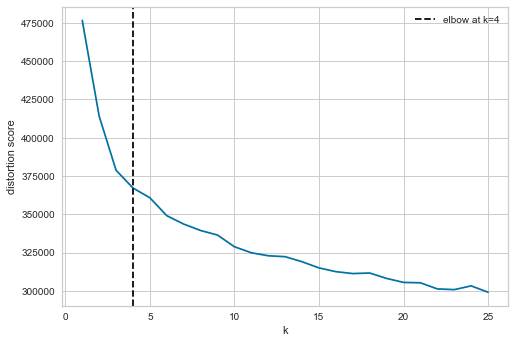

In [23]:
plt.plot(*zip(*sse))
plt.axvline(x=4, label='elbow at k=4',  ls='--', c='black')
plt.legend()
plt.xlabel("k")
plt.ylabel("distortion score")
plt.savefig("kmodes_sse.pdf", bbox_inches="tight")
plt.show()

In [562]:
from sklearn.metrics import silhouette_score

In [563]:
K = range(2, 26)
sil = []

for k in K:
    km = KModes(n_clusters=k, init='Huang', n_init=5, verbose=1, n_jobs=-1)
    sil.append((k, silhouette_score(X, km.fit_predict(X))))

Best run was number 2
Best run was number 4
Best run was number 4
Best run was number 2
Best run was number 5
Best run was number 1
Best run was number 5
Best run was number 3
Best run was number 3
Best run was number 4
Best run was number 4
Best run was number 5
Best run was number 2
Best run was number 1
Best run was number 1
Best run was number 2
Best run was number 5
Best run was number 3
Best run was number 5
Best run was number 5
Best run was number 4
Best run was number 2
Best run was number 2
Best run was number 3


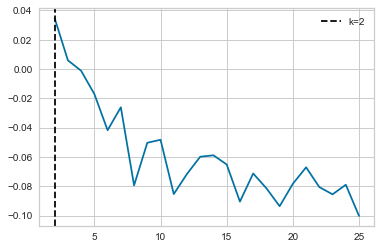

In [870]:
plt.plot(*zip(*sil))
plt.axvline(x=2, label='k=2',  ls='--', c='black')
plt.legend()
plt.savefig("kmodes_silhouette.pdf", bbox_inches="tight")
plt.show()

## Rock

In [ ]:
from pyclustering.cluster import rock #LENTO

rc = rock.rock(X2[:100], eps=0.7, number_clusters=4, threshold=0.5)
rc.process()

In [ ]:
clusters = rc.get_clusters()